<h1 style="font-family: Arial; font-weight: 900; color: magenta; text-align: center;">DIMENSIONALITY REDUCTION</h1><br>

<br/><div style="font-family: Arial; color: darkblue; font-size: 14px; font-weight: 600"><a id="toc"></a>
In this part 5:
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[1. Principal component analysis](#1)</p>
        <p style="margin: 0 0 0 4rem">[1a. Presentation. The curse of dimensionality](#1a)</p>
        <p style="margin: 0 0 0 4rem">[1b. Understanding Principal Component Analysis](#1b)</p>
        <p style="margin: 0 0 0 4rem">[1c. Coding Principal Component Analysis](#1c)</p>
        <p style="margin: 0 0 0 4rem">[1d. Principal Component Analysis in scikit-learn](#1d)</p><br/>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[2. Linear discriminant analysis](#2)</p>
        <p style="margin: 0 0 0 4rem">[2a. Presentation](#2a)</p>
        <p style="margin: 0 0 0 4rem">[2b. The LDA algorithm](#2b)</p>
        <p style="margin: 0 0 0 4rem">[2c. Coding Linear Discriminant Analysis](#2c)</p>
        <p style="margin: 0 0 0 4rem">[2d. Linear Discriminant Analysis in scikit-learn](#2d)</p><br>
    <p style="margin: 0 0 0 2rem; font-size: 16px; font-weight: 800">[3. Nonlinear dimensionality reduction](#3)</p>
        <p style="margin: 0 0 0 4rem">[3a. Presentation](#3a)</p>
        <p style="margin: 0 0 0 4rem">[3b. Example : the t-SNE and UMAP on the Digits dataset](#3b)</p></div>

In [1]:
# Suppresses all logs to avoid pointless warnings
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects
# if UMAP is not installed in your environment, simply create a cell
# (eg above this one) and run '!pip install umap-learn'
from umap import UMAP

# The datasets we will use
df_wine = pd.read_csv('wine.data', header=None)
from sklearn.datasets import load_digits

# Beautify the code results by using colors
from colorama import Fore, Back, Style
# Define some strings for cleaner codes
BB = Fore.BLUE + Style.BRIGHT
MB = Fore.MAGENTA + Style.BRIGHT

# Beautify figures by rendering them in SVG quality instead of JPG
# (don't use this if you prefer lightweight notebooks)
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")

<a id="1"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>1. PRINCIPAL COMPONENT ANALYSIS</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>1a. Presentation. The curse of dimensionality</font><a id="1a"></a></p>$\quad$
        The average distance between two points in a unit square is roughly $0.52$ ; it is roughly $0.66$ for two points in a unit cube ; and it is roughly $408.25$ for two points in a $10^6$ dimensional unit hypercube. Hence datasets with many features are at risk of being very sparse. And new instances will likely be far away from any training instance, making predictions much less reliable than in lower dimensions. This problem is often referred to as the <font color = darkpink>curse of dimensionality</font>.<br>$\quad$
        In theory, one solution to the curse of dimensionality could be to increase the size of the training set to reach a sufficient density of training instances. Unfortunately, with just $100$ features (and many Machine Learning problems involve thousands or even millions of features), we would need more training instances than there are atoms in the observable universe in order for training instances to be within $0.1$ of each other on average.<br>$\quad$
        In most real-world problems, training instances are not spread out across all dimensions. For example, consider the MNIST images : the pixels on the images' borders are almost always white, so you could completely drop these pixels from the training set without losing much information. Similarly, in general, the training instances actually lie within (or close to) a much lower-dimensional subspace than their original features' space. In the previous part ("4. Selecting meaningful features"), we have seen some techniques to select the most meaningful features without transforming the dataset. In this part we will see various techniques transforming or projecting the dataset onto a new feature space.<br>$\quad$
        We begin with principal component analysis.

<br><br><div style="font-family: Arial; font-size:14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>1b. Understanding Principal Component Analysis</font><a id="1b"></a></p>$\quad$
        Before we can project the training set onto a lower-dimensional subspace, we first need to choose the right subspace. Once a dimension $d$ for this subspace has been decided, <font color = darkpink>PCA (Principal Component Analysis)</font> first identifies the subspace of dimension $d$ which lies closest to the data, and then it projects the data onto it. It is by far the most popular dimensionality reduction algorithm.<br>
    PCA finds this subspace incrementally. First it finds the line which minimizes the mean squared distance from it to the dataset instances, or rather its direction (unit) vector <font color = darkpink>$w^{(1)}$</font>, called the <font color = darkpink>first principal component</font>; then it restricts the dataset to the hyperplane perpendicular to $w^{(1)}$, and finds there the line which minimizes the mean squared distance to the projected instances, or rather its direction vector $w^{(2)}$, called the second principal component ; and so on ; the $k$-th direction vector is called the <font color = darkpink>$k$-th principal component</font> and is denoted by <font color = darkpink>$w^{(k)}$</font>.

<figure style="text-align: center;">
    <img src="5.1. Principal components in dim 2.png" alt="Figure showing some data points enclosed in an ellipse; the first principal component is a unit vector on the major axis, and the second is a perpendicular unit vector, on the minor axis. The drawing shows a wrongfully small PC2 (both vectors are unit vectors, and thus should have the same length)." width="300" />
    <figcaption style="margin-top: .5rem; font-weight: bold; color: purple">Principal component axes in dimension 2</figcaption>
</figure>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    Before running the algorithm, we first standardize the dataset (see part 2, "3d. Standardization"). So we have a training matrix $\, X \in \mathbb{R}^{m \,\times\, n}$ whose features (columns) have mean $0$ and variance $1$.<br>$\quad$
    The first principal component is a unit vector of the straight line which is closest to the data points, in the sense that it minimizes the sum of the squared distances between itself and the data points :<br><font color = darkpink>
    $$w^{(1)} \;=\; \underset{w \,\in\, \mathbb{R}^n \,,\, \lVert w \rVert=1}{\text{argmin}}\;\, \left(\sum_{i=1}^{m} \text{dist}\left(x^{(i)} \,,\, (O,w)\right)^2 \right) \,\qquad (1)$$</font>$\quad$
    Since<br><font color = purple>
    $$\forall i = 1,\cdots,m \quad \forall w\in\mathbb{R}^n \; \text{ s.t. } \lVert w \rVert=1 \quad \lVert Ox^{(i)} \rVert^2 = (x^{(i)}.w)^2 + \text{dist}(x^{(i)}, (O,w))^2 \,\qquad (2)$$</font>$\quad$
    and since $\lVert Ox^{(i)} \rVert^2$ does not depend on $w$, this is equivalent to finding<br><font color = darkpink>
    $$w^{(1)} \;=\; \underset{w \,\in\, \mathbb{R}^n \,,\, \lVert w \rVert=1}{\text{argmax}}\;\, \left(\sum_{i=1}^{m} \left(x^{(i)}.w\right)^2 \right) \;=\; \underset{w \,\in\, \mathbb{R}^n \,,\, \lVert w \rVert=1}{\text{argmax}}\;\, \lVert Xw \rVert^2 \;=\; \underset{w \,\in\, \mathbb{R}^n \,,\, \lVert w \rVert=1}{\text{argmax}}\;\, \left(w, X^T X w\right) \,\qquad (3)$$</font><br>$\quad$
    Note that since the features have mean $0$, <font color = purple>$X^T X$ is $n$ times the covariance matrix of the features</font>.

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    $X^T X$ is positive, so its eigenvalues are positive and it has a basis composed of orthonormal eigenvectors. We can order the eigenvalues in decreasing order $\lambda_1 \geq \lambda_2 \geq \cdots \geq \lambda_n \geq 0$ and call the associated orthonormal vectors $\,\xi_1, \xi_2, \cdots, \xi_n \,\in\, \mathbb{R}^n$. With these notations<br><font color = purple>
    $$\forall \eta \,=\, \sum_{l=1}^n \eta_l \, \xi_l \,\in\, \mathbb{R}^n \qquad X^T X \eta \,=\, \sum_{l=1}^n \eta_l \, \lambda_l \, \xi_l \quad \text{and} \quad \lVert \eta \rVert^2 \,=\, \sum_{l=1}^n \eta_{l}^2 \,\qquad (4)$$</font>$\quad$
    So for any $w$ of norm $1$ we have<br><font color = purple>
    $$\left(w, X^T X w\right) \;=\; \sum_{l=1}^n w_{l}^2 \, \lambda_l \;\leq\; \sum_{l=1}^n w_{l}^2 \, \lambda_1 \;=\; \lambda_1 \;=\; \left(\xi_1, X^T X \xi_1\right) \,\qquad (5)$$</font><br>$\quad$
    Hence $\xi_1$ is a solution of $(1)$, ie <font color = darkpink>the first principal component is the eigenvector of the covariance matrix (of the features) associated with the largest eigenvalue</font>.

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    Following the plan presented at the beginning of the section, we construct the hyperplane perpendicular to $\xi_1$; it is the eigensubspace generated by $\xi_2, \cdots, \xi_n$; let's call it $F_1$. We call $p_1$ the orthogonal projection onto $F_1$, so the projections of the instances are $p_1(x^{(1)}), \cdots, p_1(x^{(m)})$. And we want to find the straight line which minimizes the mean squared distance from it to these projections or, equivalently, a unit vector $w^{(2)}$ such that<br><font color = darkpink>
    $$w^{(2)} \;=\; \underset{w \,\in\, F_1 \,,\, \lVert w \rVert=1}{\text{argmin}}\;\, \left(\sum_{i=1}^{m} \text{dist}\left(p_1(x^{(i)}) \,,\, (O,w)\right)^2 \right) \,\qquad (6)$$</font>$\quad$
    $(2)$ remains valid and since<br><br><font color = purple>
    $$\forall w \in F_1 \qquad p_1(x^{(i)}).w \,=\, x^{(i)}.w \,\qquad (7)$$</font>$\quad$
    $(3)$ becomes<br><font color = darkpink>
    $$w^{(2)} \;=\; \underset{w \,\in\, F_1 \,,\, \lVert w \rVert=1}{\text{argmax}}\;\, \left(\sum_{i=1}^{m} \left(x^{(i)}.w\right)^2 \right) \;=\; \underset{w \,\in\, F_1 \,,\, \lVert w \rVert=1}{\text{argmax}}\;\, \lVert Xw \rVert^2 \;=\; \underset{w \,\in\, F_1 \,,\, \lVert w \rVert=1}{\text{argmax}}\;\, \left(w, X^T X w\right) \,\qquad (8)$$</font><br><br>$\quad$
    Now, since for any $\eta$ in the eigensubspace $F_1$ there exist real numbers $\eta_2, \cdots, \eta_n$ such that<br><font color = purple>
    $$\eta = \sum_{l=2}^n \eta_l \, \xi_l \,\qquad (9)$$</font>$\quad$
    so<font color = purple>
    $$X^T X \eta \,=\, \sum_{l=2}^n \eta_l \, \lambda_l \, \xi_l \quad \text{and} \quad \lVert \eta \rVert^2 \,=\, \sum_{l=2}^n \eta_{l}^2 \,\qquad (10)$$</font>$\quad$
    and for any $w$ in $F_1$ of norm $1$ we have<br><font color = purple>
    $$\left(w, X^T X w\right) \;=\; \sum_{l=2}^n w_{l}^2 \, \lambda_l \;\leq\; \sum_{l=2}^n w_{l}^2 \, \lambda_2 \;=\; \lambda_2 \;=\; \left(\xi_2, X^T X \xi_2\right) \,\qquad (11)$$</font><br>$\quad$
    Hence $\xi_2$ is a solution of $(6)$, ie <font color = darkpink>the second principal component is the eigenvector of the covariance matrix (of the features) associated with the second largest eigenvalue</font>.

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    And so on, by induction. At step $k+1$, for any $i \leq k$ the $i$-th principal component is the eigenvector associated with the $i$-th largest eigenvalue. We call $F_k$ the subspace orthogonal to the subspace generated by the $k$ first principal components, which is also the eigensubspace generated by $\xi_{k+1}, \cdots, \xi_n$, and $p_k$ the orthogonal projection onto $F_k$. We have $p_k(p_{k-1}(x^{(i)})) = p_k(x^{(i)})$ and for any vector $w$ in $F_k$ we have $p_k(x^{(i)}).w = x^{(i)}.w$ so a straight line in $F_k$ which minimizes the mean of the squared distances to the projections of the datapoints has a direction (unit) vector $w$ in $F_k$ which maximizes $\left(w, X^T X w\right)$, and since $\lambda_{k+1}$ is the largest eigenvalue in $F_k$ we can take $\xi_{k+1}$ as this direction vector. We get :<br>$\quad$
    <font color = darkpink>For any $\,k=1,\cdots,n\;$ the $k$-th principal component is the eigenvector of the covariance matrix (of the features) associated with the $k$-th largest eigenvalue</font>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    Say we do not want to use all the $n$ features of our dataset, and rather than keeping the $n$ components of our instances $x^{(i)}$ we only want to keep the $d \leq n$ components of their projections onto the <font color = purple>subspace $E_d$ generated by the $d$ first principal components</font>, ie $\left(x^{(i)}\,,\,\xi_j\right)_{j=1}^{d}$. So we compute the $d$ first principal components and, rather than training our predictive algorithms over our initial training matrix $X$, we train them on the smaller matrix $X^{(d)}\,$ whose coefficients are<br><font color = purple>
    $$X_{ij}^{(d)} \,=\, \left(x^{(i)}\,,\,\xi_j\right) \qquad \forall i=1,\cdots,m \quad\forall j=1,\cdots,d \,\qquad (12)$$

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let's define $X^{(d)}\,$ directly from $X$.<br>
First, we call $\left(e_{i}^{(n)}\right)_{i=1}^{n}$, for any integer $n$, the natural orthonormal basis of $\mathbb{R}^n$<br><font color = purple>
    $$\forall n\in\mathbb{N}^* \quad \forall i=1,\cdots,n \quad e_{i}^{(n)}=\left(\delta_{ij}\right)_{j=1}^{n} \quad\text{where}\quad \forall j=1,\cdots,n \quad \delta_{ij}= \begin{cases} 1 \;\text{ if }\; i=j \\  0 \;\text{ otherwise} \end{cases} \,\qquad (13)$$</font>
    and we define<font color = darkpink>
    $$\forall d=1,\cdots,n \qquad W^{(d)}:u=\left(u_k\right)_{k=1}^{d} \in \mathbb{R}^d \;\;\mapsto\;\; \sum_{k=1}^{d} u_k\,\xi_k \in \mathbb{R}^n \,\qquad (14)$$<br></font>
    so, since <font color = purple>$\; x^{(i)} = X^T e_{i}^{(n)}$</font>,<br><font color = purple>
    $$\forall i=1,\cdots,m \quad \forall j=1,\cdots,d \qquad X_{ij}^{(d)} = \left(X^T e_{i}^{(n)} \,,\, \xi_j\right) = \left(e_{i}^{(n)} \,,\, X \, \xi_j\right) = \left(e_{i}^{(n)} \,,\, X \, W^{(d)} \, e_{j}^{(d)} \right) \,\qquad (15)$$<br></font>
    Hence <font color = darkpink>we will train our predictive algorithms over<br>
    $$X^{(d)} \;=\; X\,W^{(d)} \;=\; \left( \, X\xi_1 \;\vert\; \cdots \;\vert\; X\xi_d \, \right) \,\qquad (16)$$<br></font>
    In particular, our new instances are<font color = purple>
    $$x_{new}^{(i)} \;=\; x^{(i)} \, W^{(d)} \,\qquad (17)$$

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Note that<font color="purple">
        $$\begin{align} \forall i,j=1,\cdots,d \quad & \left(e_{i}^{(d)}\,,\, X^{(d) \, T} \, X^{(d)} \, e_{j}^{(d)}\right) = \left(X^{(d)} \, e_{i}^{(d)} \,,\, X^{(d)} \, e_{j}^{(d)}\right) = \left(X \, W^{(d)} \, e_{i}^{(d)}\,,\, X \, W^{(d)} \, e_{j}^{(d)}\right) = \\
        & \qquad = \left(X \, \xi_i, X \, \xi_j\right) = \left( \xi_i \,,\, X^T \, X \, \xi_j \right) = \left( \xi_i \,,\, \lambda_j \, \xi_j \right) = \lambda_j \, \delta_{ij} \,\qquad (18) \end{align}$$</font>
    shows that$\quad$
        $$X^{(d) \, T} \, X^{(d)} \;=\; \text{Diag}\left(\lambda_1, \cdots, \lambda_d\right) \,\qquad (19)$$<br></font>$\quad$
        Since the eigenvalues $\lambda_k$ are equal to the eigenvalues of the covariance matrix up to a multiple, it makes sense to call <font color = purple>variance ratio</font> the quantity<br><font color = purple>
    $$\forall d = 1,\cdots,n \quad vr_d \;=\; \frac{\sum_{k=1}^d \lambda_k}{\sum_{k=1}^n \lambda_k} \;=\; \frac{\text{trace}\left(X^{(d) \, T} \, X^{(d)}\right)}{\text{trace}\left(X^{T} \, X\right)} \,\qquad (20)$$</font>$\quad$
    We have<br><font color = purple>
    $$vr_d \, \text{ is closer to } 1 \iff d \, \text{ is closer to } \, n \iff E_d \, \text{ is closer to } \, \mathbb{R}^n \iff X^{(d)} \, \text{ is closer to } \, X \,\qquad (21)$$</font><br>$\quad$
        Thus the variance ratio is a way to measure the error we make when we use $X^{(d)}$ instead of $X$. We will often choose the smallest $d$ such that the variance ratio is $\geq 95\%$ ; or we will look at the variance ratios curve as a function of $d$ and choose $d$ accordingly.<br>$\quad$
        The individual ratio<font color = darkpink>
    $$evr_k := \frac{\lambda_k}{\sum_{k=1}^n \lambda_k}\,\qquad (22)$$</font>
is called the <font color = darkpink>explained variance ratio</font>, so the variance ratio is also called the <font color = darkpink>cumulative sum of explained variance ratios</font>, which is the term used by the author and is more specific to this context.

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>1c. Coding Principal Component Analysis</font><a id="1c"></a></p>$\quad$
        First, let's upload the wine dataset that we first used in part 4, "3a. Partitioning a dataset between a training and a test dataset". The first feature is the labels of the wines (there are three different labels), then there are 13 features for the training matrix. Then, we split the dataset into a training matrix and a test matrix, the latter containing $30\%$ of the data points. And finally, we standardize the training features and transform the test matrix accordingly :

In [2]:
# reads the "wine.data" in the folder; this dataset has no header
df_wine = pd.read_csv('wine.data', header=None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# the labels are in column 0
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
# 'stratify=y' ensures that the class distribution is preserved during the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# 'StandardScaler' standardizes the features
sc = StandardScaler()
# we standardize the training matrix and apply the same transformation to the test matrix
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

# numpy's formula for the covariance between two n-dimensional vectors X and Y uses the normalization's
# factor 1/((n-1)(n-2)) instead of 1/n (or 1/(n-1) for statistics) so here (there are 13 features) their
# covariance matrix is equal to 1/123 times X.T times X
XtX = np.dot(X_train_std.T, X_train_std)
# compute the covariance matrix according to Numpy's formula
cov_mat = 1/123*XtX

eigen_vals, eigen_vecs = np.linalg.eigh(cov_mat)
print(BB + "Eigenvalues computed from numpy's crazy definition of the covariance matrix :\n" + MB,
      eigen_vals)  

eigen_vals2, eigen_vecs2 = np.linalg.eigh(XtX)
print(BB + "True values of for the eigenvalues (normalization factor 1/n instead of 1/((n-1)(n-2))) :\n" +
      MB, eigen_vals2/13)

# since the eigenvalues given by numpy are ordered in increasing order the first component is the last
# eigenvector, the second is the second-last and so on; [-1:-4:-1] asks to go from the last element
# (included) to the fourth last (excluded) by steps of -1
print(BB + "3 first principal components :\n" + MB, eigen_vecs[-1:-4:-1])

Eigenvalues computed from numpy's crazy definition of the covariance matrix :
 [0.10754642 0.15362835 0.1808613  0.21357215 0.3131368  0.34650377
 0.51828472 0.6620634  0.84166161 0.96120438 1.54845825 2.41602459
 4.84274532]
True values of for the eigenvalues (normalization factor 1/n instead of 1/((n-1)(n-2))) :
 [ 1.01755462  1.45356054  1.71122619  2.02072108  2.96275588  3.27845871
  4.90377083  6.26413836  7.9634137   9.09447219 14.65079728 22.85930955
 45.81982106]
3 first principal components :
 [[-0.01211126 -0.03873952 -0.36776336  0.54253207  0.51727846  0.00560817
  -0.00081134  0.13801839 -0.12802904  0.16768217 -0.07065022 -0.38022942
  -0.29669651]
 [-0.18764627 -0.74222954 -0.23783528 -0.01912058 -0.23808956  0.11082755
  -0.13054014  0.17584238 -0.06662756 -0.14201609  0.13239103  0.24902536
  -0.36861022]
 [-0.12906113 -0.04046698  0.53248388  0.09846946  0.02119612 -0.45976229
   0.30264066  0.14167338 -0.27691422  0.36905375  0.05305915  0.20716433
  -0.32613263]]


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let's calculate the cumulative sum of explained variance ratios, which we will then plot via Matplotlib’s step function :

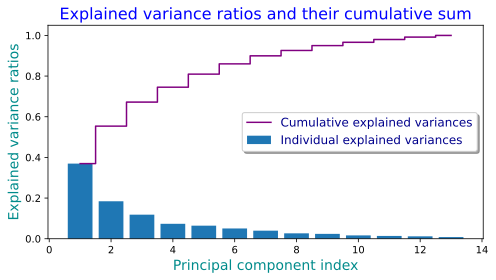

In [3]:
# Calculate the total sum of eigenvalues
tot = sum(eigen_vals)
# Calculate the explained variance for each principal component, sorted from the first to the last
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
# Calculate the cumulative explained variance
cum_var_exp = np.cumsum(var_exp)

# Create a bar plot for the individual explained variances
plt.figure(figsize=(7, 4))
plt.title("Explained variance ratios and their cumulative sum", fontsize=16, color='blue')
plt.bar(range(1,14), var_exp, align='center', label='Individual explained variances')

# Create a step plot for the cumulative explained variances
plt.step(range(1,14), cum_var_exp, where='mid', label='Cumulative explained variances',
         color="purple")
plt.ylabel("Explained variance ratios", fontsize=14, color='darkcyan')
plt.xlabel("Principal component index", fontsize=14, color='darkcyan')
plt.legend(loc='best', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Now that we know the sets of the eigenvalues and of the corresponding eigenvectors, let's sort them by descending order of the eigenvalues, construct a projection matrix from the selected eigenvectors, and use the projection matrix to transform the data onto the lower-dimensional subspace. Here we will use only the first two eigenvectors for the purpose of illustration, since we are going to plot the data via a two-dimensional scatterplot later in this subsection.
In practice, the number of principal components has to be determined by a tradeoff between
computational efficiency and the performance of the classifier :

In [4]:
# creates a list of tuples, where each tuple contains an eigenvalue (eigen_vals[i]) and its
# corresponding eigenvector (eigen_vecs[:, i])
eigen_pairs = [(eigen_vals[i], eigen_vecs[:, i]) for i in range(len(eigen_vals))]
# in Python, a lambda function is a small anonymous function. In this case, lambda k: k[0] defines a
# function that takes an argument k and returns its first element (k[0]). So
# 'eigen_pairs.sort(key=lambda k: k[0], reverse=True)' sorts 'eigen_pairs' in decreasing order of
# their first elements
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

# 'eigen_pairs[0][1]' returns the eigenvector associated with the first eigenvalue;
# xi_1 = 'eigen_pairs[0][1][:, np.newaxis]' transforms it into a 13x1 matrix
# xi_2 = 'eigen_pairs[1][1][:, np.newaxis]' is the 13x1 matrix composed of the components of the
# second principal component
# 'np.hstack((xi_1, xi_2))' is the 13x2 matrix whose i-th column is xi_i
W = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print(BB + "Matrix W:\n" + MB, W)

Matrix W:
 [[-0.13724218 -0.50303478]
 [ 0.24724326 -0.16487119]
 [-0.02545159 -0.24456476]
 [ 0.20694508  0.11352904]
 [-0.15436582 -0.28974518]
 [-0.39376952 -0.05080104]
 [-0.41735106  0.02287338]
 [ 0.30572896 -0.09048885]
 [-0.30668347 -0.00835233]
 [ 0.07554066 -0.54977581]
 [-0.32613263  0.20716433]
 [-0.36861022  0.24902536]
 [-0.29669651 -0.38022942]]


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Our new matrix, $X^{(2)}$, is given by

In [5]:
X_train_pca = X_train_std @ W
print(BB + "The new first instance is :" + MB, X_train_pca[0])

The new first instance is : [ 2.38299011 -0.45458499]


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let’s visualize the transformed wine training dataset $X^{(2)}$, which is a $124 \times 2$-dimensional matrix, in a two-dimensional scatterplot :

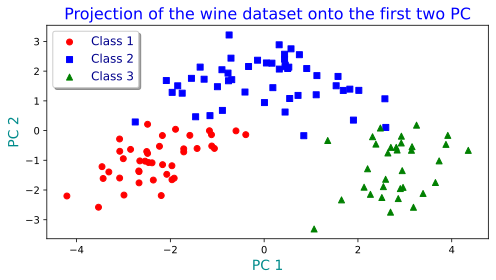

In [6]:
plt.figure(figsize=(7, 4))
plt.title("Projection of the wine dataset onto the first two PC", fontsize=16, color='blue')
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], X_train_pca[y_train==l, 1], c=c, label=f'Class {l}',
                marker=m)
plt.xlabel('PC 1', fontsize=14, color='darkcyan')
plt.ylabel('PC 2', fontsize=14, color='darkcyan')
plt.legend(loc='upper left', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        As we can see, the data is more spread along the first principal component ($x$ axis) than
the second principal component ($y$ axis), which is consistent with the explained variance ratio plot
that we created in cell 3. However, we can tell that a linear classifier will likely be able to separate the classes well.<br>$\quad$
        Although we encoded the class label information for the purpose of illustration in the preceding scatterplot, we have to keep in mind that PCA is an unsupervised technique that doesn’t use any class label information.

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>1d. Principal Component Analysis in scikit-learn</font><a id="1d"></a></p>$\quad$
        Although the verbose approach in the previous subsection helped us to follow the inner workings of PCA, we will now discuss how to use the PCA class implemented in <font color='green'>scikit-learn</font>.<br>$\quad$
        The PCA class is another one of <font color='green'>scikit-learn</font>’s transformer classes, with which we first fit the model using the training data before we transform both the training data and the test dataset using the same model parameters.<br>$\quad$
        Now, let’s use the PCA class from <font color='green'>scikit-learn</font> on the wine training dataset, classify the transformed examples via logistic regression, and visualize the decision regions via the
'plot_decision_regions' function that I improved with the help of ChatGPT in part 3 ("1c. Presenting the perceptron's results with Matplotlib").<br><br>
    <p style="margin: 0 0 0 2rem; font-size: 15px; font-weight: 600"><font color='purple'>$\quad$Note :</font></p> $\quad$
    In general, we will only use <font color='green'>scikit-learn</font>, so we would first need to know how many principal components we would like to use; as seen in "1c. Coding Principal Component Analysis", one way to do this is by using the explained variance ratios. In <font color='green'>scikit-learn</font>, this is done via the ' <font color='green'>explained_variance_ratio_<font color='darkblue'> ' attribute of <font color='green'>scikit-learn</font>'s ' <font color='green'>PCA<font color='darkblue'> ' class. To get them all, we need to use '<font color='green'>n_components=None<font color='darkblue'>' (which is the default value).

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
print(BB + "Explained variance ratios :\n" + MB, pca.explained_variance_ratio_)
print(BB + "Cumulative sums of the explained variance ratios :\n" + MB,
      np.cumsum(pca.explained_variance_ratio_))

Explained variance ratios :
 [0.36951469 0.18434927 0.11815159 0.07334252 0.06422108 0.05051724
 0.03954654 0.02643918 0.02389319 0.01629614 0.01380021 0.01172226
 0.00820609]
Cumulative sums of the explained variance ratios :
 [0.36951469 0.55386396 0.67201555 0.74535807 0.80957914 0.86009639
 0.89964293 0.92608211 0.9499753  0.96627144 0.98007165 0.99179391
 1.        ]


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        It appears that we would need $9$ principal components to get $95\%$ of the complete explained variance ratio, which is not much less than our initial $13$ features.<br>$\quad$
        Anyway, now we project onto the $2$ dimensional space generated by our two first principal components in order to represent the data points and visualize the decision regions that we can get with $2$ principal components. First we reload our 'plot_decision_regions' function.

In [8]:
def plot_decision_regions(X, y, classifier, resolution=0.02, test_idx=None):
    # all notations below are mine
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    # 'np.unique' collects the different values in an array and display them only once, in an 
    # ascending order :
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # 'np.arange(x1_min, x1_max, resolution)' generates a 1-dimensional array with values ranging from
    # x1_min to x1_max with a step size of 'resolution'. Here this represents the set of coordinates
    # along the first dimension.
    # 'np.arange(x2_min, x2_max, resolution)' does the same for the second dimension
    # At last, if x and y are 1d arrays of dim m and n resp. then 'np.meshgrid' returns two 2D arrays
    # of dimensions n*m : the first is composed of n rows of x, and the second is composed of m 
    # columns of y
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    # the 'ravel()' method flattens any 2D array into a 1d array by writing its rows one after the 
    # other from top to bottom so 'np.array([xx1.ravel(), xx2.ravel()]).T' is a 2D dimensinal array of
    # dim mn*2 whose m first rows are the coordinates of all the points of ordinate x2_min with their
    # abscissae in ascending order, the following m rows are the coordinates of all the points of
    # ordinate x2_min + resolution with their abscissae in ascending order, etc.
    # so 'lab' is a 1d array of dim mn; its first m elements are the predictions for the m points of
    # ordinate x2_min, the m following elements are the predictions for the m points of ordinate
    # x2_min + resolution, etc.
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    # now 'lab' is the n*m array of predictions for the coordinates of the points in the grid; the
    # second row (from the top) of 'lab' corresponds to the predictions for the second row (from the
    # top as well) of the grid because on a computer screen ascending ordinates go from top to bottom
    lab = lab.reshape(xx1.shape)
    # 'plt.contourf(X, Y, Z, cmap=None, alpha=None)' has many other optional parameters. It traces a
    # contour based on a grid whose coordinates are referenced by 'X' and 'Y' (here 'xx1' and 'xx2')
    # such that to each point on the grid is associated a value given by 'Z'; according to its value
    # each point is given a color defined by the colormap 'cmap' earlier defined and a transparency
    # 'alpha'. Note that 'plt.contourf' does colorize the entire grid, not only a contour.'
    plt.contourf(xx1, xx2, lab, cmap=cmap, alpha=0.3)
    # sets the x-axis limits of the plot to span from the minimum value of the array xx1 to the
    # maximum value of xx1. 
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # 'np.unique(y)' is defined above; 'enumerate' iterates over the array and returns the pairs
    # index/value
    for idx, cl in enumerate(np.unique(y)):
        #* X[y == cl, 0] is the first column of the sub-array of 'X' composed of the rows
        # corresponding to the class 'cl'
        #* x=X[y == cl, 0], y=X[y == cl, 1] are the 'x' and 'y' coordinates of the points to be
        # plotted
        #* c=colors[idx] : each point should receive the color corresponding to its index 'idx'
        #* marker=markers[idx] : each point should receive the marker style registered at
        # 'markers[idx]'
        #* label=f'Class {cl}' defines a label for all the points corresponding to the current class
        # 'cl'.  It will be used in the legend of the plot.
        #* edgecolor='black' : the color of the markers' edges will be black
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], c=colors[idx], alpha=0.8, marker=markers[idx],
                    label=f'Class {cl}', edgecolor='black')
    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        #* 'linewidth=1' means that the lines are 1 point in width, a point being of size 1/72 inch
        #* 's' is the surface area of a square bounding the marker, so here the markers are bounded by
        # squares of side length 10/72 inch 
        plt.scatter(X_test[:, 0], X_test[:, 1], c='none', edgecolor='black', alpha=1.0, linewidth=1,
                    marker='o', s=100, label='Test set')

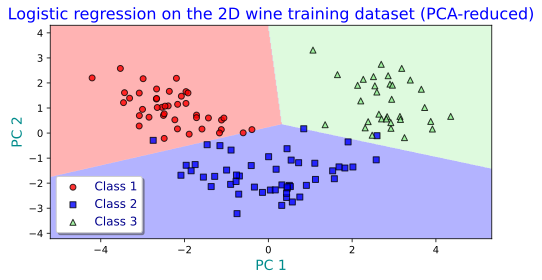

In [9]:
from sklearn.linear_model import LogisticRegression
# initializing the PCA transformer and logistic regression estimator:
pca = PCA(n_components=2)
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
# dimensionality reduction:
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
# fitting the logistic regression model on the reduced dataset:
lr.fit(X_train_pca, y_train)

plt.figure(figsize=(7, 4))
plt.title("Logistic regression on the 2D wine training dataset (PCA-reduced)", fontsize=16, color='blue')
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1', fontsize=14, color='darkcyan')
plt.ylabel('PC 2', fontsize=14, color='darkcyan')
plt.legend(loc='lower left', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Let’s plot the decision regions of the logistic regression on the transformed test dataset to see if it can separate the classes well :

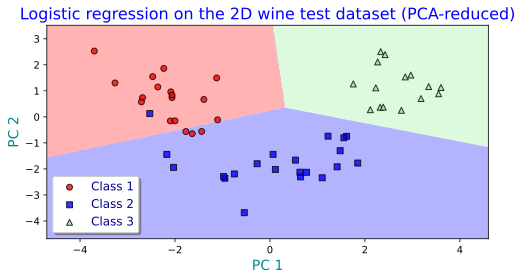

In [10]:
plt.figure(figsize=(7, 4))
plt.title("Logistic regression on the 2D wine test dataset (PCA-reduced)", fontsize=16, color='blue')
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1', fontsize=14, color='darkcyan')
plt.ylabel('PC 2', fontsize=14, color='darkcyan')
plt.legend(loc='lower left', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.tight_layout()
plt.show()

<a id="2"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>2. LINEAR DISCRIMINANT ANALYSIS</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2a. Presentation</font><a id="2a"></a></p>$\quad$
        Alike PCA (Principal Component Analysis), <font color = darkpink>LDA</font> (<font color = darkpink>Linear Discriminant Analysis</font>) is a linear transformation technique that can be used to reduce the number of dimensions in a dataset, but whereas PCA attempts to find the orthogonal component axes of maximum variance in a dataset, the goal in LDA is to find the feature subspace that optimizes class separability. Thus the former is an unsupervised algorithm, whereas the latter is supervised.<br>$\quad$
        In the following diagram a PCA algorithm would be happy to use the vertical axis (passing between the ellipses) as its first principal component because it would be the closest to the datapoints, this axis would not be suitable for the LDA technique, which would rather choose the horizontal axis because projecting on the horizontal axis would best separate the two classes of points.

<figure style="text-align: center;">
    <img src="5.2. The concept of LDA for a two-class problem.png" alt="The diagram shows two vertical ellipses, containing each the element of one class only; the ellipse on the left contains circles and the one on the right contains pluses. Hence PCA would project onto the y-axis, mixing the circles and pluses, while LDA would project onto the x-axis, keeping them cleanly separated." width="300" />
    <figcaption style="margin-top: .5rem; font-weight: bold; color: purple">The concept of LDA for a two-class problem</figcaption>
</figure>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        LDA relies on several assumptions : that the data is normally distributed, that the classes have identical covariance matrices, and that the training examples are statistically independent of each other. However, even if one, or more, of those assumptions is slightly violated, LDA for dimensionality reduction can still work reasonably well.<br>$\quad$
        In his rather complete book "Hands-on machine learning" (ed O'Reilly, 2023, 1199p.), A. Géron only devotes 7 lines to this subject (in "Other dimensionality reduction techniques", p.338), and the author we follow, S. Raschka, only quotes articles dating back to 2001 or earlier, so I will not present the technique in detail, just summarize what is in the book.

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2b. The LDA algorithm</font><a id="2b"></a></p>$\quad$
        As usual, we start with a training matrix <font color = 'purple'>$X$</font> $\in \mathbb{R}^{m\,\times\,n}$, which contains <font color = 'purple'>$\,m\,$</font> instances (rows) <font color = 'purple'>$\,x^{(i)}\,$</font> and <font color = 'purple'>$\,n\,$</font> features <font color = 'purple'>$\,X_j\,$</font>. We suppose that the instances belong to classes, and we denote by <font color = purple>$\,c\,$</font> the number of classes. Then, for any $\,k=1, \cdots, c\,$, <font color = purple>$\,C_k\,$</font> denotes the set of instances in the $k$-th class, <font color = purple>$\,I_k\,$</font> denotes the subset of $\{1, \cdots, m\}$ composed of the indices of the instances belonging to $C_k$, and <font color = purple>$\,m_k\,$</font> denotes the number of instances in the $k$-th class, ie the cardinal of $C_k$. We successively define :<br>
* for each class $\,k = 1, \cdots, c\;$ the <font color = darkpink>mean of the class $C_k$</font> is the $\mathbb{R}^n$-vector<br><font color = purple>
    $$\mu_k \;=\; \frac{1}{m_k} \,\sum_{l \in I_k}\, x^{(l)} \,\qquad (23)$$</font>
* the <font color = darkpink>mean of the instances</font> is the $\mathbb{R}^n$-vector<br><font color = purple>
    $$\mu \;=\; \frac{1}{m} \;\sum_{i=1}^{m} x^{(i)} \;=\; \frac{1}{m} \;\sum_{k=1}^{c} \,m_k \; \mu_k \,\qquad (24)$$</font>
* for each class $\,k = 1, \cdots, c\;$ the <font color = darkpink>scatter matrix of the class $C_k$</font> is the $\mathbb{R}^{n\,\times\,n}$-matrix<br><font color = purple>
    $$S_k \;=\; \sum_{l \in I_k} \left(x^{(l)}-\mu_k\right)^T \, \left(x^{(l)}-\mu_k\right) \,\qquad (25)$$</font>
* the <font color = darkpink>within-class scatter matrix</font> is the $\mathbb{R}^{n\,\times\,n}$-matrix<font color = purple>
    $$S_W \;=\; \sum_{k=1}^{c} S_k \,\qquad (26)$$</font>
* the <font color = darkpink>between-class scatter matrix</font> is the $\mathbb{R}^{n\,\times\,n}$-matrix<br><font color = purple>
    $$S_B \;=\; \sum_{k=1}^{c} m_k \, \left(\mu_k - \mu\right)^T \, \left(\mu_k - \mu\right) \,\qquad (27)$$

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The <font color = darkpink>LDA algorithm</font> consists in performing the following tasks :<br><font color = purple>$\qquad$
    1. Standardize the training matrix $X$ </font>(see part 2, "3d. Standardization")<br><font color = purple>$\qquad$
    2. For each class, compute the $n$-dimensional mean vector $\,\mu_k$; then compute $\mu$<br>$\qquad$
    3. Construct the within-class matrix $\,S_W\,$ and the between-class matrix $\,S_B$<br>$\qquad$
    4. Compute the eigenvalues and corresponding orthonormal eigenvectors of the matrix $\,S_{W}^{-1} \, S_B$<br>$\qquad$
    5. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors<br>$\qquad$
    6. Select the $\,d\,$ eigenvectors that correspond to the $\,d\,$ largest eigenvalues to construct a $(n \!\times\! d)$-dimensional transformation matrix, <font color = darkpink>$\,W\,$<font color = purple>, whose $k$-th column is the $k$-th eigenvector<br>$\qquad$
    7. The eigenvectors generate the new feature subspace; project the instances onto it using $W$, ie  the new training matrix will be <font color = darkpink>$\; X_{new} \,=\, X \, W$

<div style="margin: 0; font-family: Arial; color: darkblue; font-size: 12; font-weight: 500"><br>$\quad$
        As we can see, LDA is quite similar to PCA in the sense that we are decomposing matrices into eigenvalues and eigenvectors, which will form the new lower-dimensional feature space. However, as
mentioned before, LDA takes class label information into account, which is represented in the form
of the mean vectors computed in step 2.

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2c. Coding Linear Discriminant Analysis</font><a id="2c"></a></p>$\quad$
        In this section, we will code the LDA dimensionality reduction algorithm using the wine dataset as an example. The first step of the algorithm, "Standardize the training matrix $X$" has already been done in cell 2. So now we do the second step, "compute the $n$-dimensional mean vectors" :

In [11]:
# set the precision for printing numpy floats to 4 decimal places
np.set_printoptions(precision=4)
mean_vecs = []
# there are only 3 classes in the wine dataset
for label in range(1,4):
    # compute the mean of the instances of class 'label'
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print(BB + "Mean Vector", label, ":" + MB, mean_vecs[label - 1], "\n")

Mean Vector 1 : [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075] 

Mean Vector 2 : [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253] 

Mean Vector 3 : [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013] 



<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        We can now compute the within-class scatter matrix $S_W$, the between-class scatter matrix $S_B$, and then $\,S_{W}^{-1} \, S_B$ :

In [12]:
# there are 13 features in the wine dataset
n = 13

# compute S_W
S_W = np.zeros((n, n))
for label, mv in zip(range(1, 4), mean_vecs):
    # compute the scatter matrix of the 'label' class
    class_scatter = np.zeros((n, n))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(1, n), mv.reshape(1, n)
        class_scatter += (row - mv).T @ (row - mv)
    S_W += class_scatter

# compute the mean of the instances
mean_overall = np.mean(X_train_std, axis=0).reshape(1,n)

# compute S_B
S_B = np.zeros((n, n))
for k in range(3):
    m_k = X_train_std[y_train == k + 1, :].shape[0]
    S_B += m_k * (mean_vecs[k] - mean_overall).T @ (mean_vecs[k] - mean_overall)

# compute Z := inv(S_W) @ S_B
Z = np.linalg.inv(S_W) @ S_B

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    The eigenvectors of $\,S_{W}^{-1} \, S_B\,$ are called the <font color = darkpink>linear discriminants</font>. We compute the eigenvalues and their corresponding eigenvectors; we replace the eigenvalues with their absolute values and rank the pairs in descending order; we see that all eigenvalues but two are almost $0$, so we only give the value of the first three.

In [13]:
eigen_vals, eigen_vecs = np.linalg.eig(Z)
eigen_pairs = [(np.abs(eigen_vals[j]), eigen_vecs[:,j]) for j in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print(BB + "The first absolute values of the eigenvalues in descending order:" + MB)
for eigen_val in eigen_pairs[:3]:
    print(eigen_val[0])

The first absolute values of the eigenvalues in descending order:
8.262493673957486
4.225659486916684
7.981895424974964e-16


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Consequently the explained variance plot that we created in the PCA section is of little interest here : the first two linear discriminants alone capture 100 percent of the useful
information in the wine training dataset. The author plotted it anyway, so we may use the code in another context, and called the content of class-discriminatory information <font color = purple>discriminability</font> :

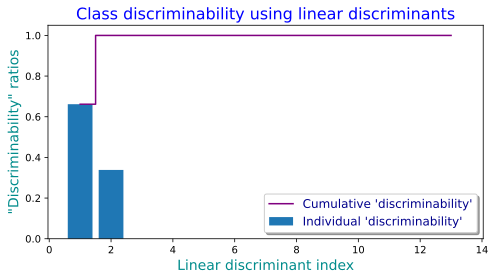

In [14]:
# Calculate the total sum of eigenvalues
tot = sum(eigen_vals.real)
# Calculate the explained variance for each linear discriminant, sorted from the first to the last
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
# Calculate the cumulative explained variance
cum_discr = np.cumsum(discr)

# Create a bar plot for the individual explained variances
plt.figure(figsize=(7, 4))
plt.title("Class discriminability using linear discriminants", fontsize=16, color='blue')
plt.bar(range(1,14), discr, align='center', label="Individual 'discriminability'")
# Create a step plot for the cumulative explained variances
plt.step(range(1,14), cum_discr, where='mid', label="Cumulative 'discriminability'",
         color="purple")
plt.ylabel('"Discriminability" ratios', fontsize=14, color='darkcyan')
plt.xlabel("Linear discriminant index", fontsize=14, color='darkcyan')
plt.legend(loc='best', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    We can now create the transformation matrix $\,W\,$; it is composed of the two linear discriminants corresponding to the two eigenvalues that are not almost $0$ :

In [15]:
W = np.hstack((eigen_pairs[0][1][:, np.newaxis].real, eigen_pairs[1][1][:, np.newaxis].real))
print(BB + 'Matrix W:\n' + MB, W)

Matrix W:
 [[-0.1586 -0.4077]
 [ 0.0984 -0.1821]
 [-0.0156 -0.3473]
 [ 0.1588  0.3095]
 [-0.0207 -0.064 ]
 [ 0.1884  0.0733]
 [-0.7153  0.3034]
 [-0.0798 -0.0009]
 [ 0.0074  0.0716]
 [ 0.3448 -0.2808]
 [-0.0254  0.244 ]
 [-0.3192 -0.0459]
 [-0.4054 -0.5806]]


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    We can now project the wine datapoints onto the $2$-dimensional vector space generated by the two linear discriminants we have just found. We see that the three wine classes are perfectly linearly separable in the new feature subspace :

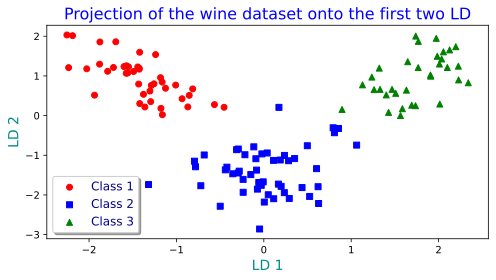

In [16]:
X_train_lda = X_train_std.dot(W)

plt.figure(figsize=(7, 4))
plt.title("Projection of the wine dataset onto the first two LD", fontsize=16, color='blue')
colors = ['r', 'b', 'g']
markers = ['o', 's', '^']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0], X_train_lda[y_train==l, 1] * (-1), c=c,
                label= f'Class {l}', marker=m)
plt.xlabel('LD 1', fontsize=14, color='darkcyan')
plt.ylabel('LD 2', fontsize=14, color='darkcyan')
plt.legend(loc='lower left', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.tight_layout()
plt.show()

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>2d. Linear Discriminant Analysis in scikit-learn</font><a id="2d"></a></p>$\quad$
        In <font color='green'>scikit-learn</font> LDA is implemented under the class '$\,$<font color='green'>LinearDiscriminantAnalysis<font color='darkblue'>$\,$' of the '$\,$<font color='green'>discriminant_analysis<font color='darkblue'>$\,$' module.<br>$\quad$
        First we compute the cumulative explained variance ratios in order to decide how many linear discriminants we want to use :

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=None)
X_train_lda = lda.fit_transform(X_train_std, y_train)
print(BB + "Explained variance ratios :\n" + MB, lda.explained_variance_ratio_)
print(BB + "Cumulative sums of explained variance ratios :\n" + MB,
      np.cumsum(lda.explained_variance_ratio_))

Explained variance ratios :
 [0.6616 0.3384]
Cumulative sums of explained variance ratios :
 [0.6616 1.    ]


<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        Since there are only two non-zero eigenvalues, it is no wonder that only $2$ explained variance ratios are relevant. This is much better than what we got with the PCA algorithm, where we needed $9$ principal components to get $95\%$ of the complete explained variance ratio (see "1d. Principal Component Analysis in scikit-learn").<br>$\quad$
        So the choice is easy here : we transform our training matrix by projecting its instances onto the two dimensional subspace generated by the two relevant linear discriminants; then we perform a logistic regression to separate the classes linearly; and then we draw the corresponding decision regions. At last, we will test our results using the test dataset.

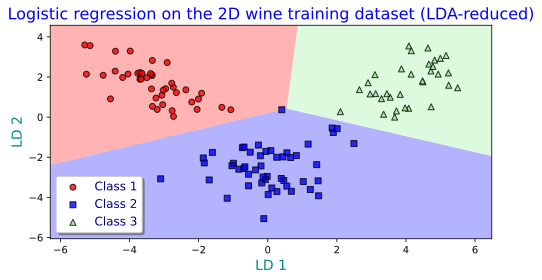

In [18]:
# initializing the LDA transformer and logistic regression estimator:
lda = LDA(n_components=2)
# C=1.0 is the default, although we would get a slightly better result if we use
# C=0.05 instead
lr = LogisticRegression(multi_class='ovr', C=1, random_state=1, solver='lbfgs')
# dimensionality reduction:
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)
# fitting the logistic regression model on the reduced dataset:
lr.fit(X_train_lda, y_train)

plt.figure(figsize=(7, 4))
plt.title("Logistic regression on the 2D wine training dataset (LDA-reduced)", fontsize=16, color='blue')
plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1', fontsize=14, color='darkcyan')
plt.ylabel('LD 2', fontsize=14, color='darkcyan')
plt.legend(loc='lower left', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        We can see that the logistic regression model misclassifies one of the examples from class $2$. By augmenting the regularization strength, we could probably shift the decision boundaries so that the logistic regression model classifies all examples in the training dataset correctly. (pr: indeed, if we use the hyperparameter 'C=0.05' then all instances of the training dataset are correctly classified). However, and more importantly, let’s take a look at the results on the test dataset :

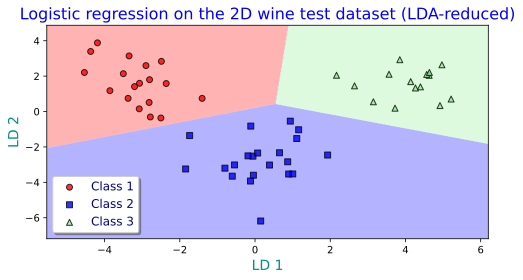

In [19]:
plt.figure(figsize=(7, 4))
plt.title("Logistic regression on the 2D wine test dataset (LDA-reduced)", fontsize=16, color='blue')
plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1', fontsize=14, color='darkcyan')
plt.ylabel('LD 2', fontsize=14, color='darkcyan')
plt.legend(loc='lower left', fancybox=True, shadow=True, fontsize=12, labelcolor='darkblue')
plt.tight_layout()
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        As we can see, the logistic regression classifier is able to get a perfect accuracy score for classifying the examples in the test dataset by only using a two-dimensional feature subspace, instead of the original 13 wine features.<br>
    (pr: the accuracy is again perfect if we use 'C=.05')

<a id="3"></a><br><br><br><div style="font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">
    <h4 style="margin: 0 0 .5rem 2rem; font-size: 18px; font-weight: 800"><font color='darkpink'>3. NONLINEAR DIMENSIONALITY REDUCTION</font></h4>
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>3a. Presentation</font><a id="3a"></a></p>$\quad$
        On this topic, the book is rather poor, and it is worth consulting "Hands-on machine learning" by A. Géron instead (pr: or my summary of it, part 5, "2. Manifold learning") to see several non-linear techniques. Still, let's summarize it here.<br>$\quad$
        If we are dealing with nonlinear problems, which we may encounter rather frequently in
real-world applications, linear transformation techniques for dimensionality reduction, such as PCA
and LDA, may not be the best choice.<br>$\quad$
        The <font color='green'>scikit-learn</font> library implements a selection of advanced techniques for nonlinear dimensionality reduction that are beyond the scope of this book. The interested reader can find a nice overview of the current implementations in <font color='green'>scikit-learn</font>, complemented by illustrative examples, at https://scikit-learn.org/stable/modules/manifold.html<br>$\quad$
        The development and application of nonlinear dimensionality reduction techniques is also often referred to as manifold learning, where manifold" has its usual meaning of a lower dimensional topological space embedded in a high-dimensional space. A classic example of manifold learning is the $3$-dimensional Swiss roll illustrated in the following figure :

<figure style="text-align: center;">
    <img src="5.3. 3D Swiss roll projections.png" alt="The diagram shows a 3D Swiss roll from three different angles, in black and white, with classes differentiated by intensity of blackness (we can not see them clearly). Below two possible reductions in 2D are presented, one good and one bad." width="500" />
    <figcaption style="margin-top: .5rem; font-weight: bold; color: purple">Two 3D Swiss roll reductions</figcaption>
</figure>

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        While nonlinear dimensionality reduction and manifold learning algorithms are very powerful, we should note that these techniques are notoriously hard to use, and with non-ideal hyperparameter
choices, they may cause more harm than good. The reason behind this difficulty is that we are often
working with high-dimensional datasets that we cannot readily visualize and where the structure is not
obvious (unlike the Swiss roll example in Figure 5.14). Moreover, unless we project the dataset into two or three dimensions (which is often not sufficient for capturing more complicated relationships), it is hard or even impossible to assess the quality of the results. Hence, many people still rely on simpler techniques such as PCA and LDA for dimensionality reduction.

<br><br><div style="font-family: Arial; font-size: 14px; color: darkblue">
    <p style="margin: 0 0 .5rem 4rem; font-size: 16px; font-weight: 600"><font color='darkpink'>3b. Example : the t-SNE and UMAP on the Digits dataset</font><a id="3b"></a></p>$\quad$
        The <font color='darkpink'>t-Distributed Stochastic Neighbor Embedding<font color='darkblue'> (<font color='darkpink'>t-SNE<font color='darkblue'>) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart; in other words, t-SNE learns to embed data points into a lower-dimensional space such that the pairwise distances in the original space are preserved. It is mostly used for visualization in $2$d ot $3$d, in particular to visualize clusters of instances in high-dimensional space (e.g. to visualize the MNIST images in $2D$). Unfortunately, since it projects the points directly (unlike PCA, it does not involve a projection matrix), we cannot apply t-SNE to new data points.<br>$\quad$
        Let's apply t-SNE to the "Digits" dataset, a $64$-dimensional set of low-resolution handwritten digits (the numbers 0-9). The digits are $8\times8$ grayscale images. The following code plots the first four images in the dataset, which consists of $1,797$ images in total, so the dataset has $1,797$ rows of instances (the images) and $64$ columns of features (the pixels) :

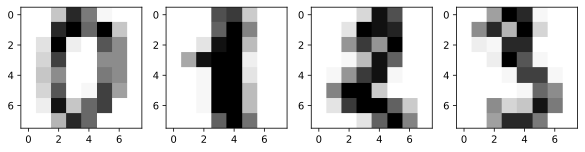

In [20]:
from sklearn.datasets import load_digits
digits = load_digits()
# there will be 4 subplots in a single row and the total figure would be 10 inches wide if printed
fig, ax = plt.subplots(1, 4, figsize=(10, 2.5))
for i in range(4):
    # displays the i-th image using a grayscale colormap
    ax[i].imshow(digits.images[i], cmap='Greys')
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        The 'digits' variable in the code has two attributes, 'digits.data' and 'digits.target', which are the dataset and the corresponding labels. We call them 'X_digits' and 'y_digits' in the following code, where we fit a 'tsne' object from <font color='green'>scikit-learn</font>'s '$\,$<font color='green'>TSNE<font color='darkblue'>$\,$' class of the '$\,$<font color='green'>manifold<font color='darkblue'>$\,$' module. The 'tsne' object is set with '$\,$<font color='green'>n_components=2<font color='darkblue'>$\,$' to get a $2$d representation, and initialized with '$\,$<font color='green'>init='pca'<font color='darkblue'>$\,$', which is the default value, and the value recommended by the author, who also advise experimenting with the hyperparameters '$\,$<font color='green'>learning_rate<font color='darkblue'>$\,$' and '$\,$<font color='green'>perplexity<font color='darkblue'>$\,$'.<br>
    According to <font color='green'>scikit-learn</font>'s website, the ideal 'learning_rate' is usually in the range [10.0, 1000.0]. And the 'perplexity' is related to the number of nearest neighbors used in other manifold learning algorithms; different values of 'perplexity' can result in significantly different results; it has a default value of $30$, and we should consider selecting a value between $5$ and $50$, with larger datasets usually requiring a larger perplexity.<br>$\quad$
        Like PCA, t-SNE is an unsupervised method, and in the preceding code, we use the class labels y_digits (0-9) only for visualization purposes :

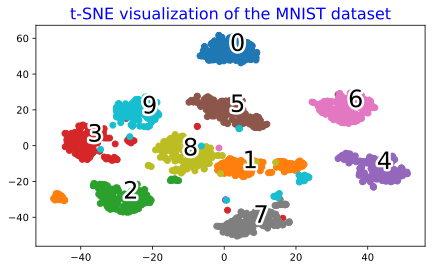

In [21]:
os.environ["LOKY_MAX_CPU_COUNT"] = str(os.cpu_count())

X_digits = digits.data
y_digits = digits.target

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=1)
X_digits_tsne = tsne.fit_transform(X_digits)

import matplotlib.patheffects as PathEffects
# I've slightly modified the original code in order to add a title to the figures
def plot_projection(x, colors, title):
    plt.figure(figsize=(7, 4))
    plt.title(title, fontsize=16, color='blue')
    for i in range(10):
        plt.scatter(x[colors == i, 0], x[colors == i, 1])
        # Compute the median position of the instances of target value i
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = plt.text(xtext, ytext, str(i), fontsize=24)
        # Add 5 lines of white around the digit label for better visibility
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])

plot_projection(X_digits_tsne, y_digits, title="t-SNE visualization of the MNIST dataset")
plt.show()

<br><div style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
        As we can see, t-SNE is able to separate the different digits (classes) nicely, although not perfectly. It might be possible to achieve better separation by tuning the hyperparameters. However, a certain degree of class mixing might be unavoidable due to poor resolution and illegible handwriting. For instance, by inspecting individual images, we might find that certain instances of the number 3 indeed look like the number 9, and so forth.<br>$\quad$
        Another popular visualization technique is <font color='darkpink'>uniform manifold approximation and projection<font color='darkblue'>
(<font color='darkpink'>UMAP<font color='darkblue'>). Not only can UMAP produce as good results as t-SNE, it is typically faster, and, alike PCA, it can also be used to project new data, which makes it more attractive than t-SNE as a dimensionality reduction technique in a machine learning context.<br>
    Let's try it on the 'digits' dataset.

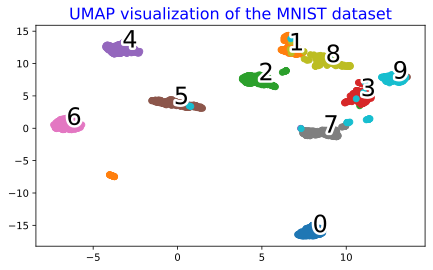

In [22]:
from umap import UMAP
umap_2d = UMAP(n_components=2, init='random')
proj_2d = umap_2d.fit_transform(X_digits)

plot_projection(proj_2d, y_digits, title="UMAP visualization of the MNIST dataset")
plt.show()

<br><span style="margin: 0; font-family: Arial; font-size: 14px; font-weight: 500; color: darkblue">$\quad$
    We see that the classes are more compactly grouped and more isolated, although there are still many mixed up instances.